# Table of Contents
 <p><div class="lev1 toc-item"><a href="#An-example-of-a-small-Single-Player-simulation" data-toc-modified-id="An-example-of-a-small-Single-Player-simulation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>An example of a small Single-Player simulation</a></div><div class="lev2 toc-item"><a href="#Creating-the-problem" data-toc-modified-id="Creating-the-problem-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Creating the problem</a></div><div class="lev3 toc-item"><a href="#Parameters-for-the-simulation" data-toc-modified-id="Parameters-for-the-simulation-111"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Parameters for the simulation</a></div><div class="lev3 toc-item"><a href="#Some-MAB-problem-with-Bernoulli-arms" data-toc-modified-id="Some-MAB-problem-with-Bernoulli-arms-112"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Some MAB problem with Bernoulli arms</a></div><div class="lev3 toc-item"><a href="#Some-RL-algorithms" data-toc-modified-id="Some-RL-algorithms-113"><span class="toc-item-num">1.1.3&nbsp;&nbsp;</span>Some RL algorithms</a></div><div class="lev2 toc-item"><a href="#Creating-the-Evaluator-object" data-toc-modified-id="Creating-the-Evaluator-object-12"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Creating the <code>Evaluator</code> object</a></div><div class="lev2 toc-item"><a href="#Solving-the-problem" data-toc-modified-id="Solving-the-problem-13"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Solving the problem</a></div><div class="lev2 toc-item"><a href="#Plotting-the-results" data-toc-modified-id="Plotting-the-results-14"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Plotting the results</a></div><div class="lev3 toc-item"><a href="#First-problem" data-toc-modified-id="First-problem-141"><span class="toc-item-num">1.4.1&nbsp;&nbsp;</span>First problem</a></div><div class="lev3 toc-item"><a href="#Second-problem" data-toc-modified-id="Second-problem-142"><span class="toc-item-num">1.4.2&nbsp;&nbsp;</span>Second problem</a></div><div class="lev3 toc-item"><a href="#Third-problem" data-toc-modified-id="Third-problem-143"><span class="toc-item-num">1.4.3&nbsp;&nbsp;</span>Third problem</a></div>

---
# An example of a small Single-Player simulation

First, be sure to be in the main folder, or to have [SMPyBandits](https://github.com/SMPyBandits/SMPyBandits) installed, and import `Evaluator` from `Environment` package:

In [5]:
!pip install SMPyBandits watermark
%load_ext watermark
%watermark -v -m -p SMPyBandits -a "Lilian Besson"

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Lilian Besson 

CPython 3.6.6
IPython 7.1.1

SMPyBandits 0.9.4

compiler   : GCC 8.0.1 20180414 (experimental) [trunk revision 259383
system     : Linux
release    : 4.15.0-38-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 4
interpreter: 64bit


In [6]:
# Local imports
from SMPyBandits.Environment import Evaluator, tqdm

We also need arms, for instance `Bernoulli`-distributed arm:

In [7]:
# Import arms
from SMPyBandits.Arms import Bernoulli

And finally we need some single-player Reinforcement Learning algorithms:

In [8]:
# Import algorithms
from SMPyBandits.Policies import *

For instance, this imported the [`UCB` algorithm](https://en.wikipedia.org/wiki/Multi-armed_bandit#Bandit_strategies) is the `UCBalpha` class:

In [9]:
# Just improving the ?? in Jupyter. Thanks to https://nbviewer.jupyter.org/gist/minrk/7715212
from __future__ import print_function
from IPython.core import page
def myprint(s):
    try:
        print(s['text/plain'])
    except (KeyError, TypeError):
        print(s)
page.page = myprint

In [10]:
UCBalpha?

Init signature: UCBalpha(nbArms, alpha=4, lower=0.0, amplitude=1.0)
Docstring:     
The UCB1 (UCB-alpha) index policy, modified to take a random permutation order for the initial exploration of each arm (reduce collisions in the multi-players setting).
Reference: [Auer et al. 02].
Init docstring:
New generic index policy.

- nbArms: the number of arms,
- lower, amplitude: lower value and known amplitude of the rewards.
File:           ~/ownCloud/owncloud.crans.org/Crans/These_2016-17/src/SMPyBandits/notebooks/venv3/lib/python3.6/site-packages/SMPyBandits/Policies/UCBalpha.py
Type:           type



With more details, here the code:

In [11]:
UCBalpha??

Init signature: UCBalpha(nbArms, alpha=4, lower=0.0, amplitude=1.0)
Source:        
class UCBalpha(UCB):
    """ The UCB1 (UCB-alpha) index policy, modified to take a random permutation order for the initial exploration of each arm (reduce collisions in the multi-players setting).
    Reference: [Auer et al. 02].
    """

    def __init__(self, nbArms, alpha=ALPHA, lower=0., amplitude=1.):
        super(UCBalpha, self).__init__(nbArms, lower=lower, amplitude=amplitude)
        assert alpha >= 0, "Error: the alpha parameter for UCBalpha class has to be >= 0."  # DEBUG
        self.alpha = alpha  #: Parameter alpha

    def __str__(self):
        return r"UCB($\alpha={:.3g}$)".format(self.alpha)

    def computeIndex(self, arm):
        r""" Compute the current index, at time t and after :math:`N_k(t)` pulls of arm k:

        .. math:: I_k(t) = \frac{X_k(t)}{N_k(t)} + \sqrt{\frac{\alpha \log(t)}{2 N_k(t)}}.
        """
        if self.pulls[arm] < 1:
            return float('+inf')
   

---
## Creating the problem

### Parameters for the simulation
- $T = 10000$ is the time horizon,
- $N = 10$ is the number of repetitions,
- `N_JOBS = 4` is the number of cores used to parallelize the code.

In [12]:
HORIZON = 10000
REPETITIONS = 10
N_JOBS = 4

### Some MAB problem with Bernoulli arms
We consider in this example $3$ problems, with `Bernoulli` arms, of different means.

In [13]:
ENVIRONMENTS = [  # 1)  Bernoulli arms
        {   # A very easy problem, but it is used in a lot of articles
            "arm_type": Bernoulli,
            "params": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
        },
        {   # An other problem, best arm = last, with three groups: very bad arms (0.01, 0.02), middle arms (0.3 - 0.6) and very good arms (0.78, 0.8, 0.82)
            "arm_type": Bernoulli,
            "params": [0.01, 0.02, 0.3, 0.4, 0.5, 0.6, 0.795, 0.8, 0.805]
        },
        {   # A very hard problem, as used in [Cappé et al, 2012]
            "arm_type": Bernoulli,
            "params": [0.01, 0.01, 0.01, 0.02, 0.02, 0.02, 0.05, 0.05, 0.1]
        },
    ]

### Some RL algorithms
We compare Thompson Sampling against $\mathrm{UCB}_1$, and $\mathrm{kl}-\mathrm{UCB}$.

In [14]:
POLICIES = [
        # --- UCB1 algorithm
        {
            "archtype": UCBalpha,
            "params": {
                "alpha": 1
            }
        },
        {
            "archtype": UCBalpha,
            "params": {
                "alpha": 0.5  # Smallest theoretically acceptable value
            }
        },
        # --- Thompson algorithm
        {
            "archtype": Thompson,
            "params": {}
        },
        # --- KL algorithms, here only klUCB
        {
            "archtype": klUCB,
            "params": {}
        },
        # --- BayesUCB algorithm
        {
            "archtype": BayesUCB,
            "params": {}
        },
    ]

Complete configuration for the problem:

In [15]:
configuration = {
    # --- Duration of the experiment
    "horizon": HORIZON,
    # --- Number of repetition of the experiment (to have an average)
    "repetitions": REPETITIONS,
    # --- Parameters for the use of joblib.Parallel
    "n_jobs": N_JOBS,    # = nb of CPU cores
    "verbosity": 6,      # Max joblib verbosity
    # --- Arms
    "environment": ENVIRONMENTS,
    # --- Algorithms
    "policies": POLICIES,
}
configuration

{'horizon': 10000,
 'repetitions': 10,
 'n_jobs': 4,
 'verbosity': 6,
 'environment': [{'arm_type': SMPyBandits.Arms.Bernoulli.Bernoulli,
   'params': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]},
  {'arm_type': SMPyBandits.Arms.Bernoulli.Bernoulli,
   'params': [0.01, 0.02, 0.3, 0.4, 0.5, 0.6, 0.795, 0.8, 0.805]},
  {'arm_type': SMPyBandits.Arms.Bernoulli.Bernoulli,
   'params': [0.01, 0.01, 0.01, 0.02, 0.02, 0.02, 0.05, 0.05, 0.1]}],
 'policies': [{'archtype': SMPyBandits.Policies.UCBalpha.UCBalpha,
   'params': {'alpha': 1}},
  {'archtype': SMPyBandits.Policies.UCBalpha.UCBalpha,
   'params': {'alpha': 0.5}},
  {'archtype': SMPyBandits.Policies.Thompson.Thompson, 'params': {}},
  {'archtype': SMPyBandits.Policies.klUCB.klUCB, 'params': {}},
  {'archtype': SMPyBandits.Policies.BayesUCB.BayesUCB, 'params': {}}]}

---
## Creating the `Evaluator` object

In [16]:
evaluation = Evaluator(configuration)

Number of policies in this comparison: 5
Time horizon: 10000
Number of repetitions: 10
Sampling rate for plotting, delta_t_plot: 1
Number of jobs for parallelization: 4
Using this dictionary to create a new environment:
 {'arm_type': <class 'SMPyBandits.Arms.Bernoulli.Bernoulli'>, 'params': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}


Creating a new MAB problem ...
  Reading arms of this MAB problem from a dictionnary 'configuration' = {'arm_type': <class 'SMPyBandits.Arms.Bernoulli.Bernoulli'>, 'params': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]} ...
 - with 'arm_type' = <class 'SMPyBandits.Arms.Bernoulli.Bernoulli'>
 - with 'params' = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
 - with 'arms' = [B(0.1), B(0.2), B(0.3), B(0.4), B(0.5), B(0.6), B(0.7), B(0.8), B(0.9)]
 - with 'means' = [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
 - with 'nbArms' = 9
 - with 'maxArm' = 0.9
 - with 'minArm' = 0.1

This MAB problem has: 
 - a [Lai & Robbins] complexity constant C(mu) = 7.52 ... 
 - a 

##  Solving the problem
Now we can simulate all the $3$ environments. That part can take some time.

In [17]:
for envId, env in tqdm(enumerate(evaluation.envs), desc="Problems"):
    # Evaluate just that env
    evaluation.startOneEnv(envId, env)



Evaluating environment: MAB(nbArms: 9, arms: [B(0.1), B(0.2), B(0.3), B(0.4), B(0.5), B(0.6), B(0.7), B(0.8), B(0.9)], minArm: 0.1, maxArm: 0.9)
- Adding policy #1 = {'archtype': <class 'SMPyBandits.Policies.UCBalpha.UCBalpha'>, 'params': {'alpha': 1}} ...
  Creating this policy from a dictionnary 'self.cfg['policies'][0]' = {'archtype': <class 'SMPyBandits.Policies.UCBalpha.UCBalpha'>, 'params': {'alpha': 1}} ...
- Adding policy #2 = {'archtype': <class 'SMPyBandits.Policies.UCBalpha.UCBalpha'>, 'params': {'alpha': 0.5}} ...
  Creating this policy from a dictionnary 'self.cfg['policies'][1]' = {'archtype': <class 'SMPyBandits.Policies.UCBalpha.UCBalpha'>, 'params': {'alpha': 0.5}} ...
- Adding policy #3 = {'archtype': <class 'SMPyBandits.Policies.Thompson.Thompson'>, 'params': {}} ...
  Creating this policy from a dictionnary 'self.cfg['policies'][2]' = {'archtype': <class 'SMPyBandits.Policies.Thompson.Thompson'>, 'params': {}} ...
- Adding policy #4 = {'archtype': <class 'SMPyBand

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of  10 | elapsed:    5.0s remaining:    5.0s
[Parallel(n_jobs=4)]: Done   7 out of  10 | elapsed:    5.0s remaining:    2.2s





- Evaluating policy #2/5: UCB($\alpha=0.5$) ...


[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    5.4s finished


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of  10 | elapsed:    1.4s remaining:    1.4s
[Parallel(n_jobs=4)]: Done   7 out of  10 | elapsed:    1.7s remaining:    0.7s





- Evaluating policy #3/5: Thompson ...


[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    2.2s finished


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of  10 | elapsed:    3.0s remaining:    3.0s
[Parallel(n_jobs=4)]: Done   7 out of  10 | elapsed:    3.3s remaining:    1.4s





- Evaluating policy #4/5: kl-UCB ...


[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    4.0s finished


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
exception calling callback for <Future at 0x7fe4882625c0 state=finished raised TerminatedWorkerError>
Traceback (most recent call last):
  File "/home/lilian/ownCloud/owncloud.crans.org/Crans/These_2016-17/src/SMPyBandits/notebooks/venv3/lib/python3.6/site-packages/joblib/externals/loky/_base.py", line 625, in _invoke_callbacks
    callback(self)
  File "/home/lilian/ownCloud/owncloud.crans.org/Crans/These_2016-17/src/SMPyBandits/notebooks/venv3/lib/python3.6/site-packages/joblib/parallel.py", line 309, in __call__
    self.parallel.dispatch_next()
  File "/home/lilian/ownCloud/owncloud.crans.org/Crans/These_2016-17/src/SMPyBandits/notebooks/venv3/lib/python3.6/site-packages/joblib/parallel.py", line 731, in dispatch_next
    if not self.dispatch_one_batch(self._original_iterator):
  File "/home/lilian/ownCloud/owncloud.crans.org/Crans/These_2016-17/src/SMPyBandits/notebooks/venv3/lib/python3.6/site-packages/job

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker. The exit codes of the workers are {SIGSEGV(-11)}

## Plotting the results
And finally, visualize them, with the plotting method of a `Evaluator` object:

In [13]:
def plotAll(evaluation, envId):
    evaluation.printFinalRanking(envId)
    evaluation.plotRegrets(envId)
    evaluation.plotRegrets(envId, semilogx=True)
    evaluation.plotRegrets(envId, meanRegret=True)
    evaluation.plotBestArmPulls(envId)

### First problem
$[B(0.1), B(0.2), B(0.3), B(0.4), B(0.5), B(0.6), B(0.7), B(0.8), B(0.9)]$


Final ranking for this environment #0 :
- Policy 'Thompson'	was ranked	1 / 5 for this simulation (last regret = 39.2).
- Policy 'UCB($\alpha=0.5$)'	was ranked	2 / 5 for this simulation (last regret = 50.56).
- Policy 'UCB($\alpha=1$)'	was ranked	3 / 5 for this simulation (last regret = 101.84).
- Policy 'kl-UCB'	was ranked	4 / 5 for this simulation (last regret = 8955.9).
- Policy 'BayesUCB'	was ranked	5 / 5 for this simulation (last regret = 8955.9).


ModuleNotFoundError: No module named 'Policies'

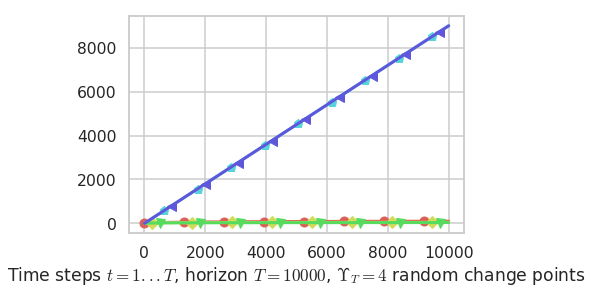

In [14]:
plotAll(evaluation, 0)

### Second problem
$[B(0.01), B(0.02), B(0.3), B(0.4), B(0.5), B(0.6), B(0.795), B(0.8), B(0.805)]$


Final ranking for this environment #1 :
- Policy 'UCB($\alpha=0.5$)'	was ranked	1 / 5 for this simulation (last regret = 65.155).
- Policy 'BayesUCB'	was ranked	2 / 5 for this simulation (last regret = 81.655).
- Policy 'Thompson'	was ranked	3 / 5 for this simulation (last regret = 84.555).
- Policy 'UCB($\alpha=1$)'	was ranked	4 / 5 for this simulation (last regret = 87.455).
- Policy 'KL-UCB(Bern)'	was ranked	5 / 5 for this simulation (last regret = 88.655).

This MAB problem has: 
 - a [Lai & Robbins] complexity constant C(mu) = 101 for 1-player problem... 
 - a Optimal Arm Identification factor H_OI(mu) = 55.39% ...


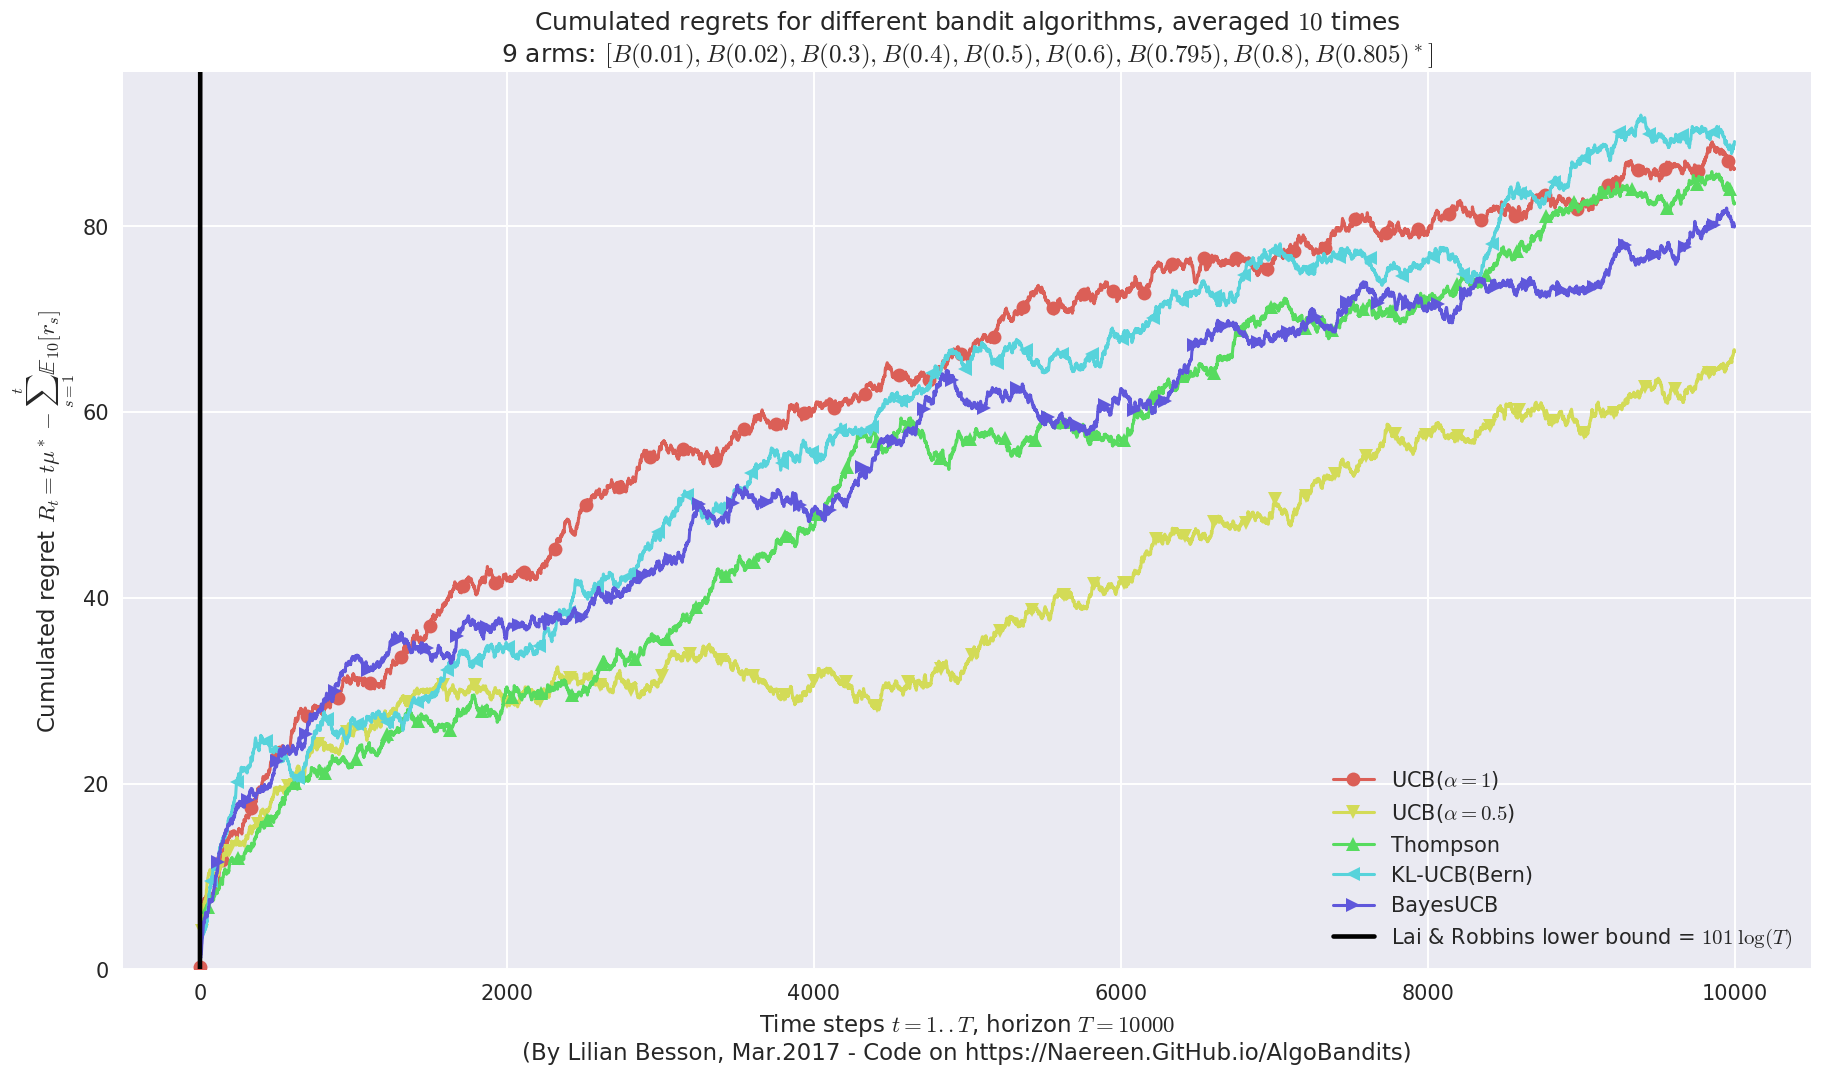


This MAB problem has: 
 - a [Lai & Robbins] complexity constant C(mu) = 101 for 1-player problem... 
 - a Optimal Arm Identification factor H_OI(mu) = 55.39% ...


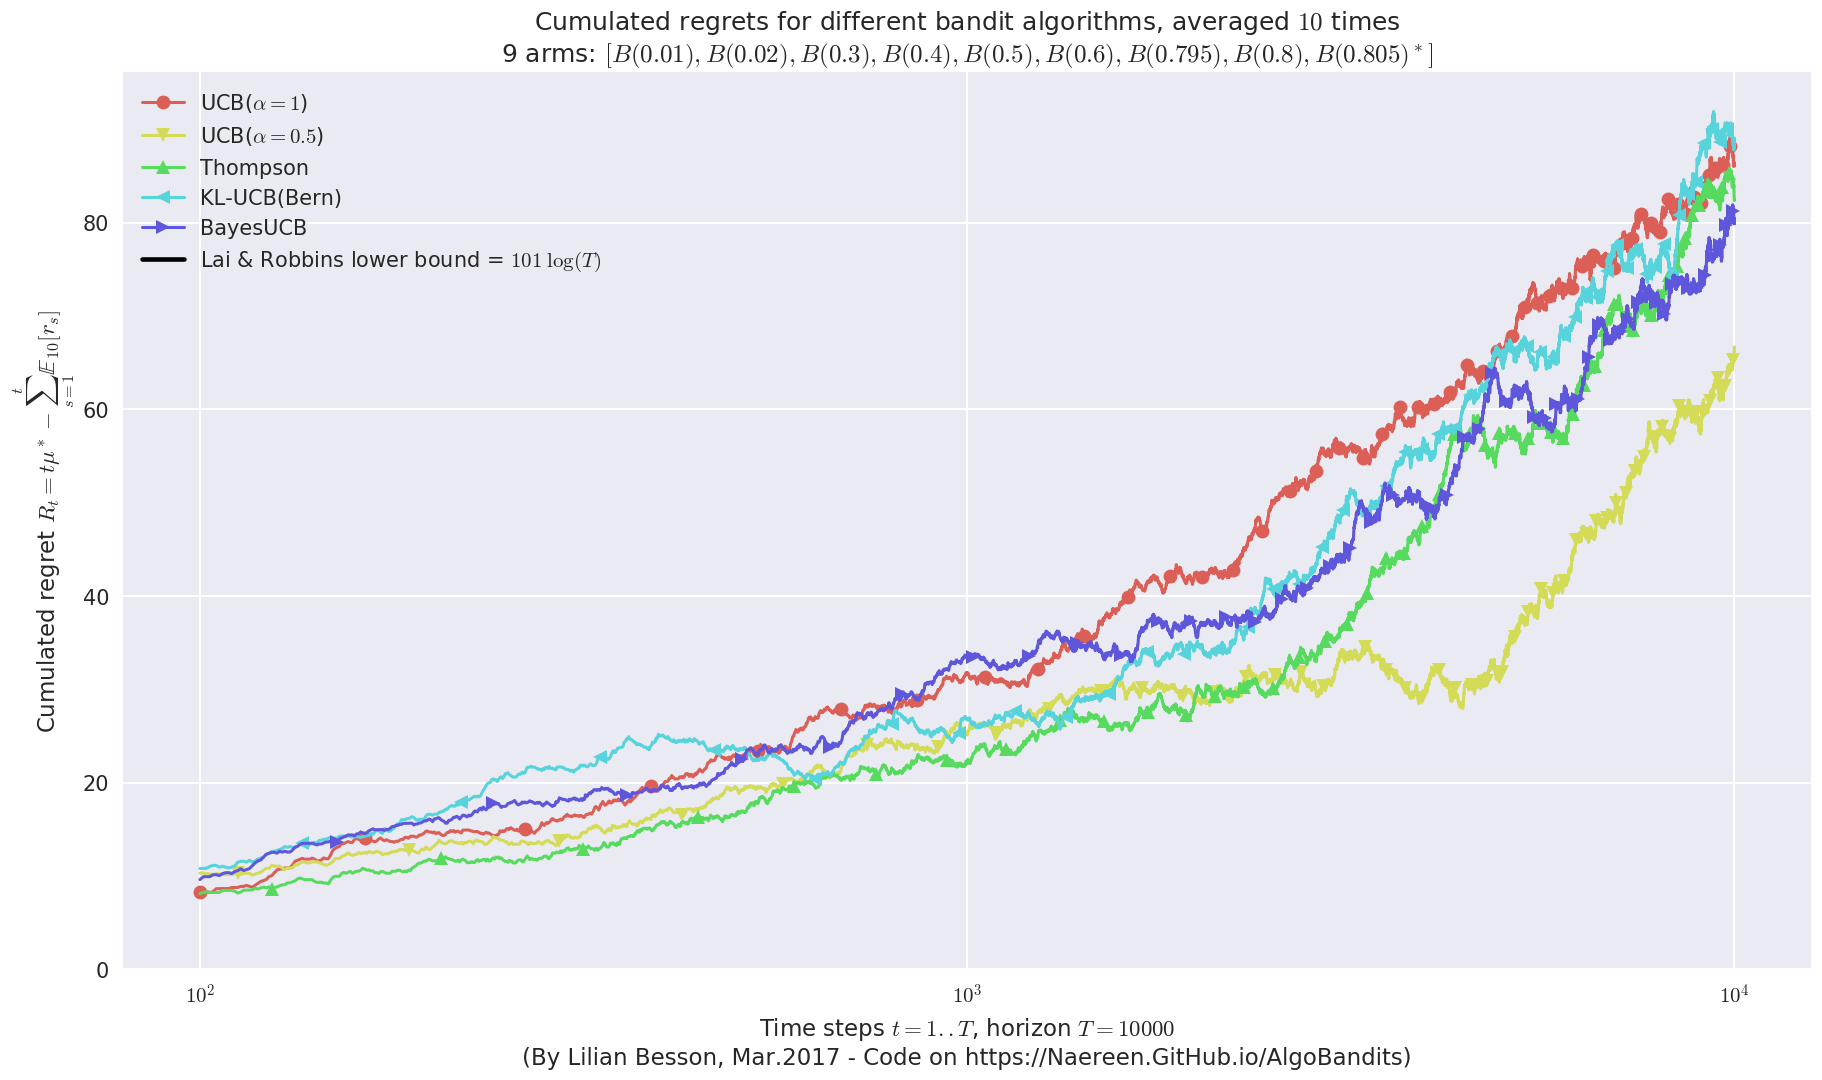


This MAB problem has: 
 - a [Lai & Robbins] complexity constant C(mu) = 101 for 1-player problem... 
 - a Optimal Arm Identification factor H_OI(mu) = 55.39% ...


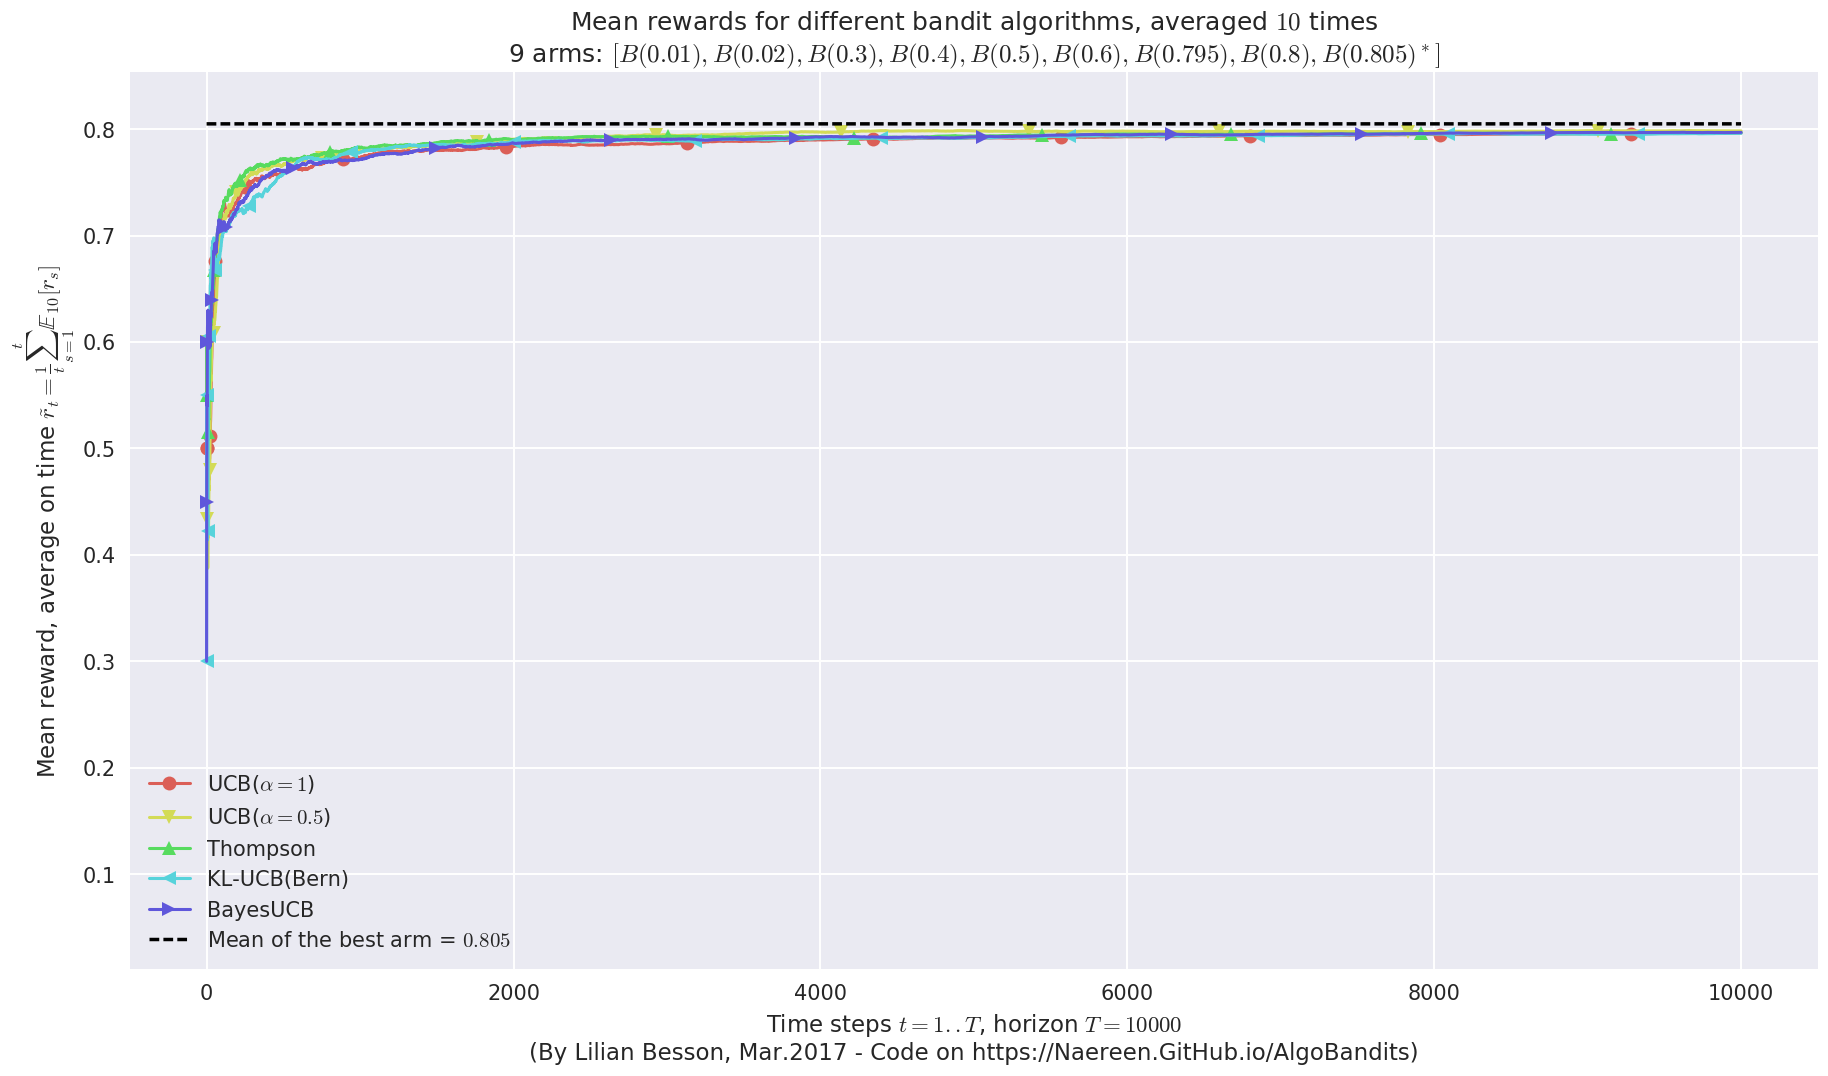

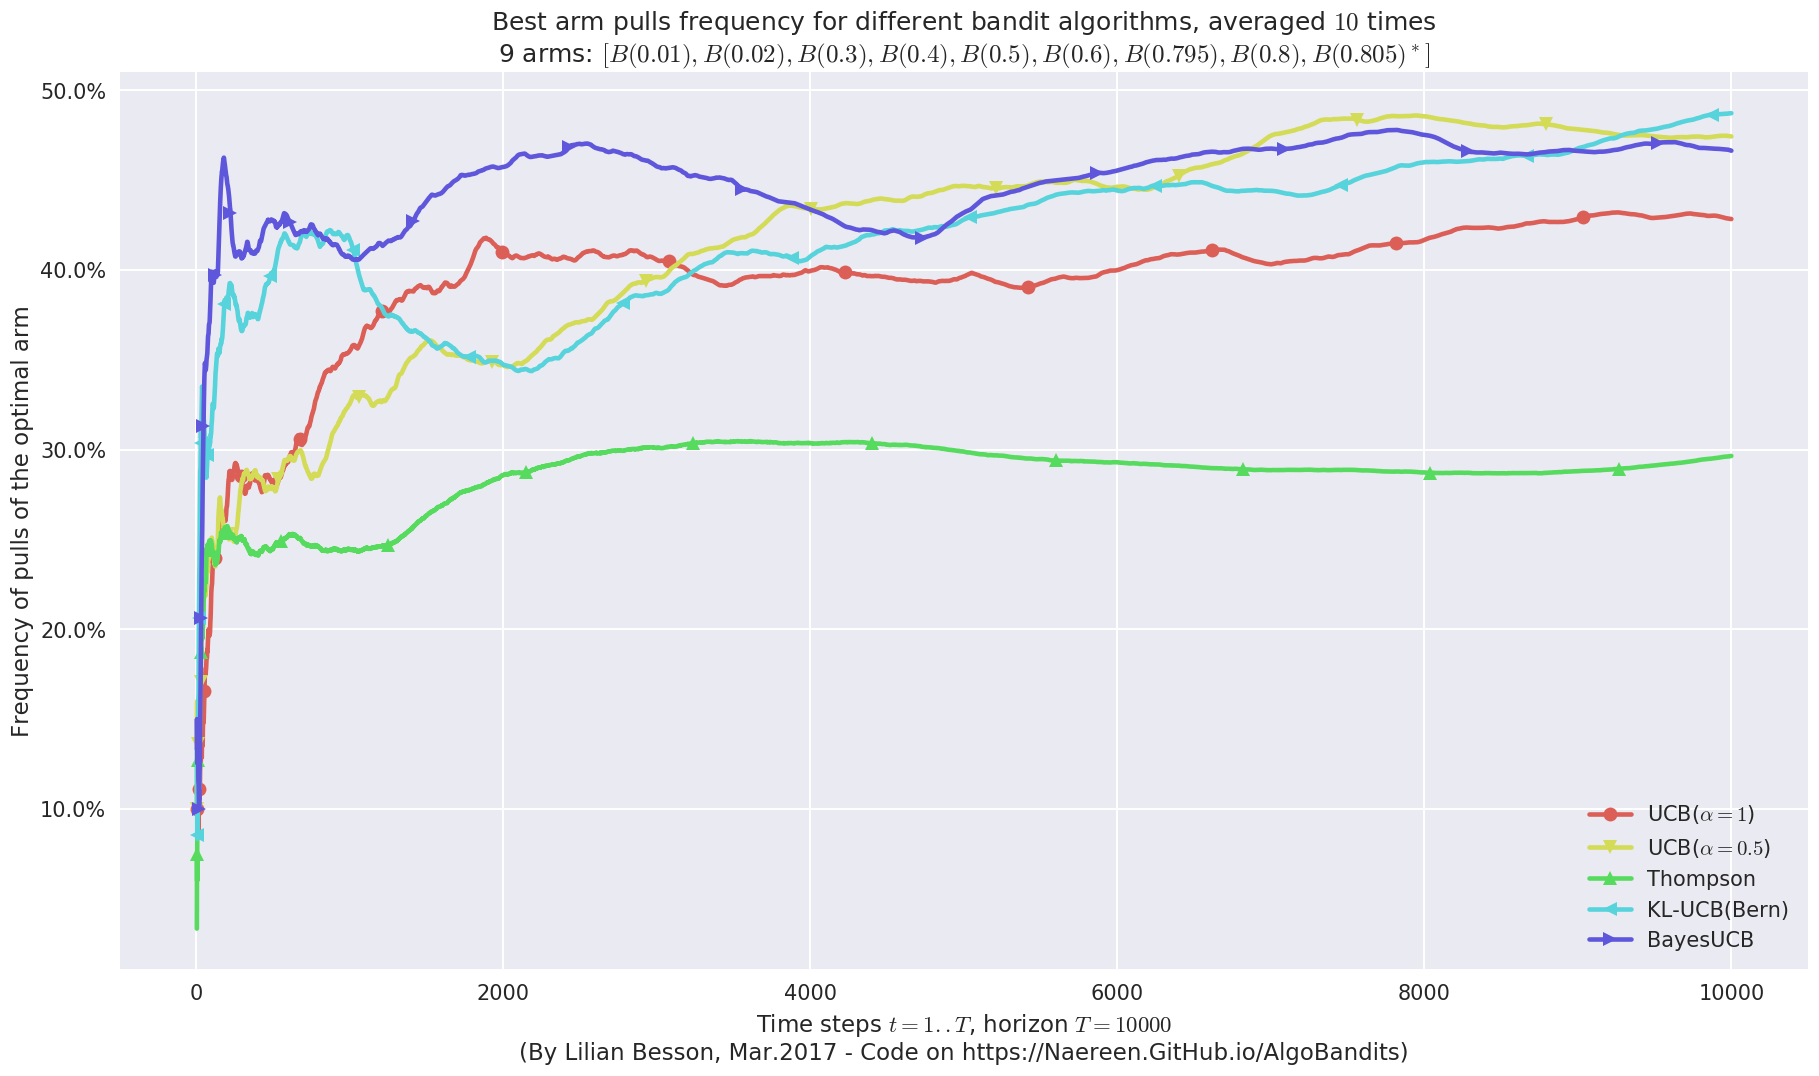

In [14]:
plotAll(evaluation, 1)

### Third problem
$[B(0.01), B(0.01), B(0.01), B(0.02), B(0.02), B(0.02), B(0.05), B(0.05), B(0.1)]$


Final ranking for this environment #2 :
- Policy 'Thompson'	was ranked	1 / 5 for this simulation (last regret = 60.4).
- Policy 'BayesUCB'	was ranked	2 / 5 for this simulation (last regret = 82.9).
- Policy 'KL-UCB(Bern)'	was ranked	3 / 5 for this simulation (last regret = 92.1).
- Policy 'UCB($\alpha=0.5$)'	was ranked	4 / 5 for this simulation (last regret = 144.1).
- Policy 'UCB($\alpha=1$)'	was ranked	5 / 5 for this simulation (last regret = 253.7).

This MAB problem has: 
 - a [Lai & Robbins] complexity constant C(mu) = 14.5 for 1-player problem... 
 - a Optimal Arm Identification factor H_OI(mu) = 82.11% ...


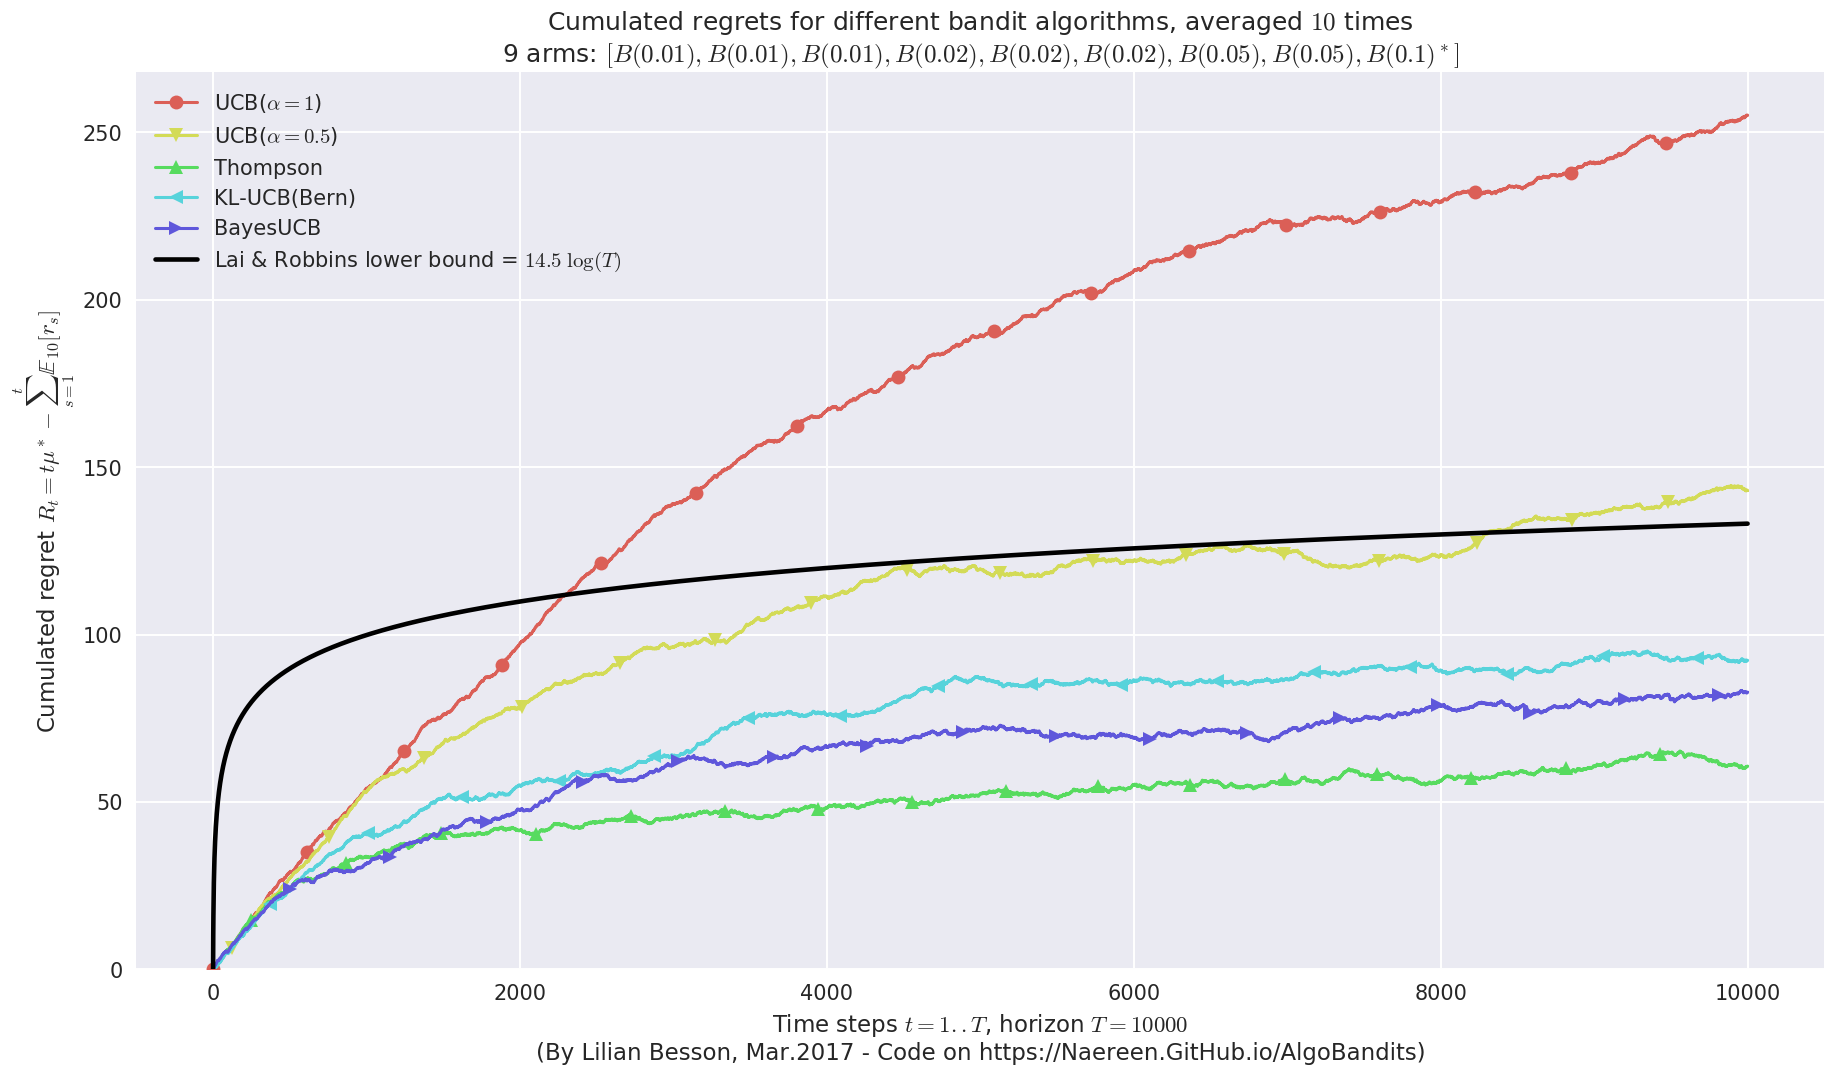


This MAB problem has: 
 - a [Lai & Robbins] complexity constant C(mu) = 14.5 for 1-player problem... 
 - a Optimal Arm Identification factor H_OI(mu) = 82.11% ...


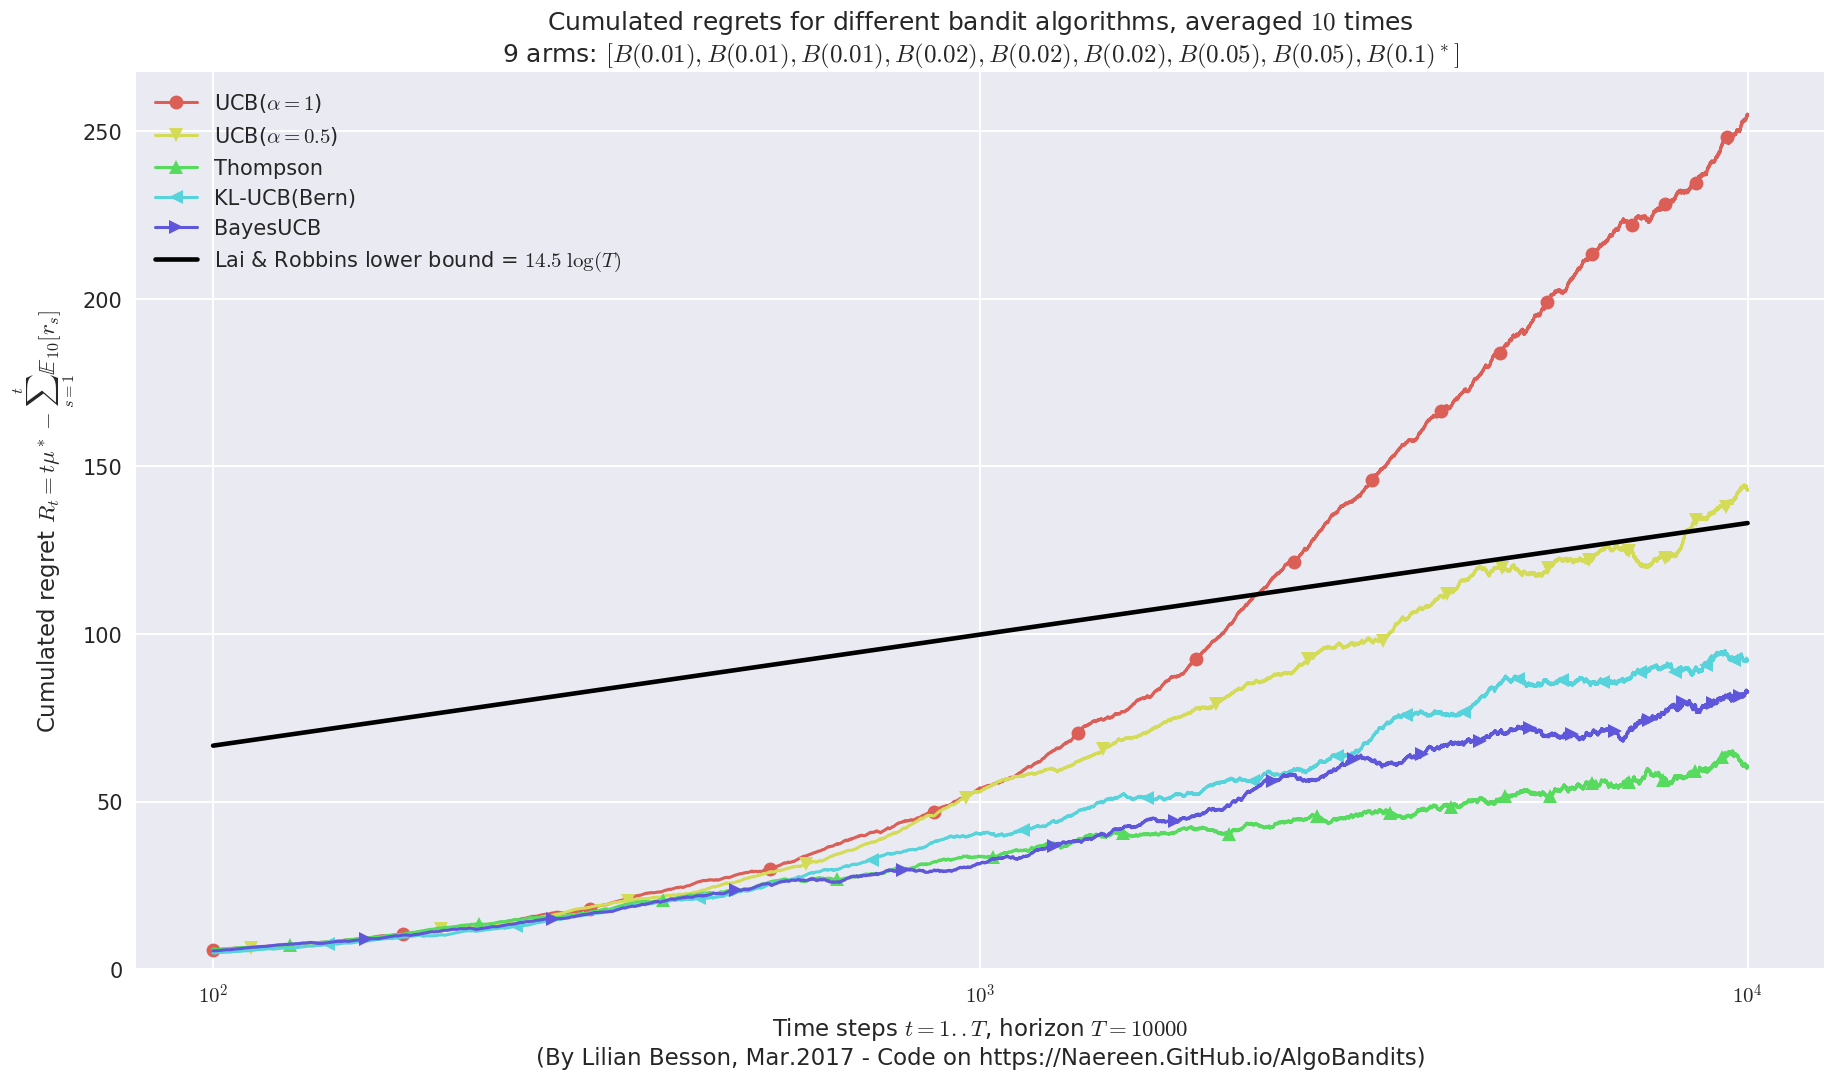


This MAB problem has: 
 - a [Lai & Robbins] complexity constant C(mu) = 14.5 for 1-player problem... 
 - a Optimal Arm Identification factor H_OI(mu) = 82.11% ...


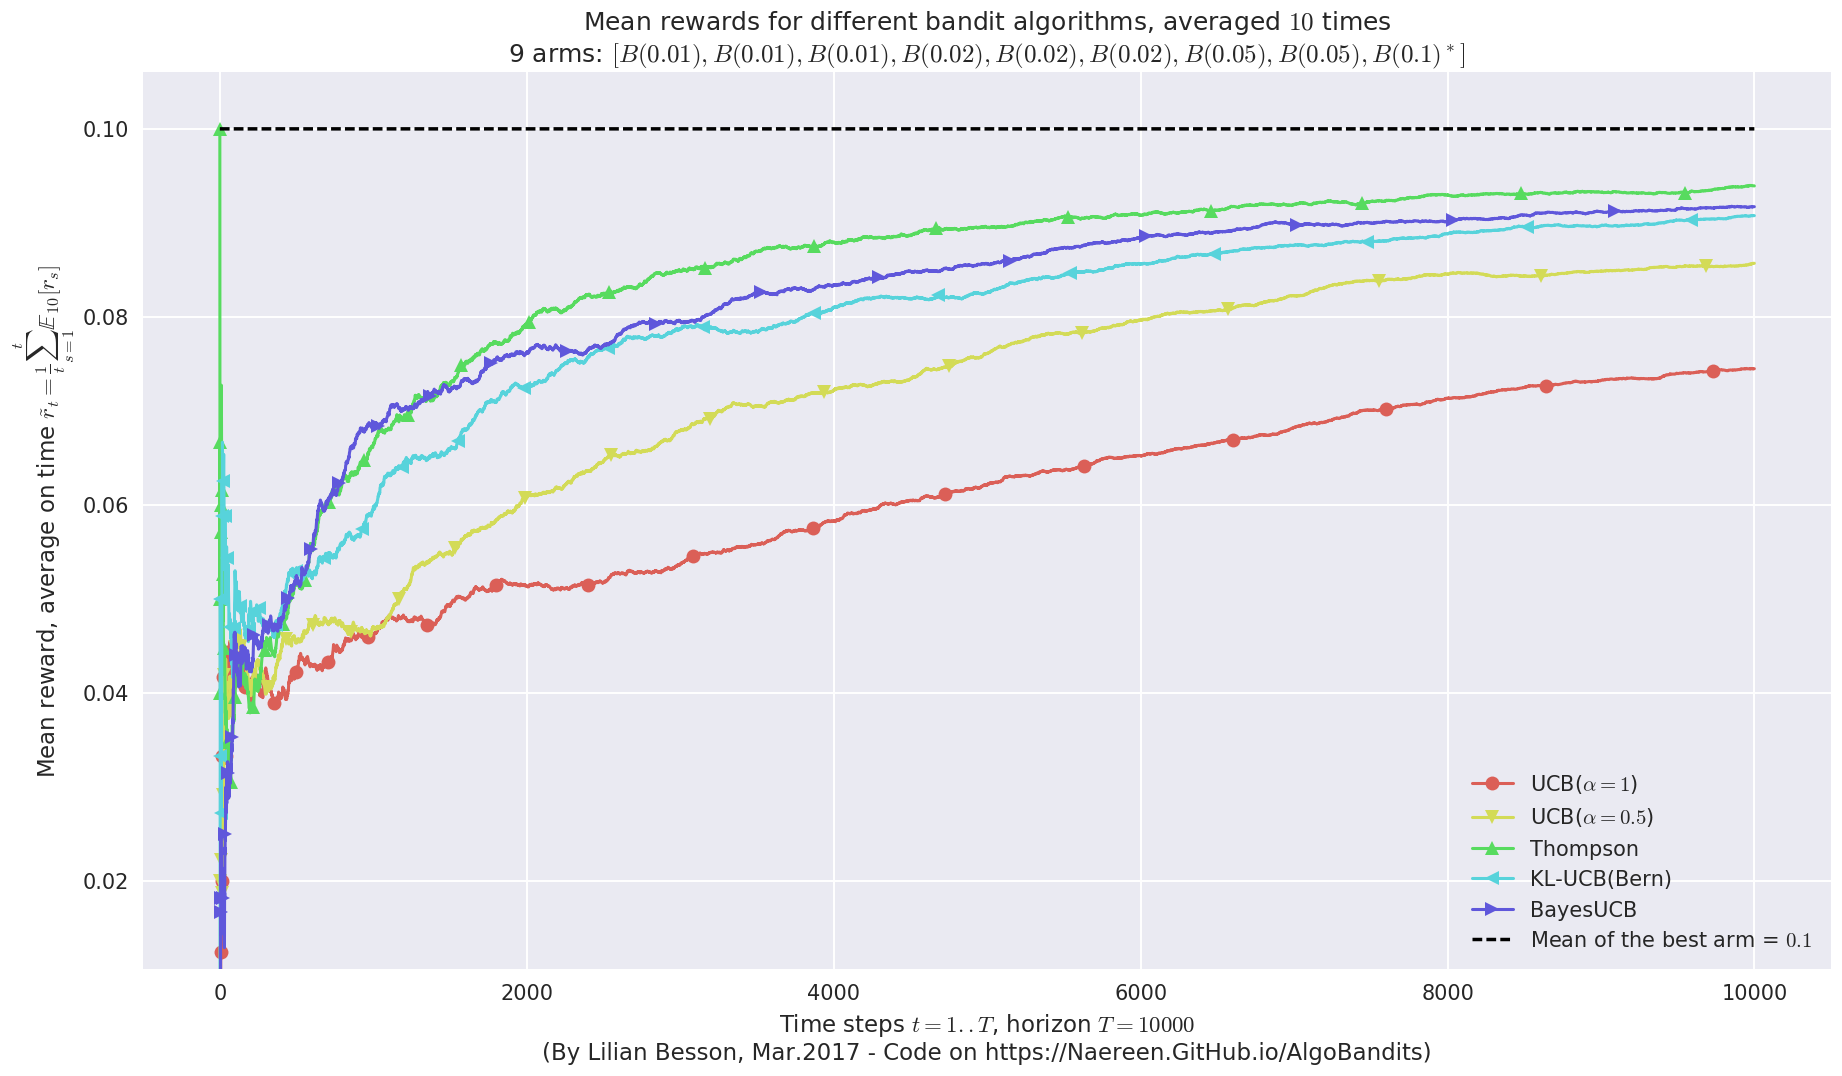

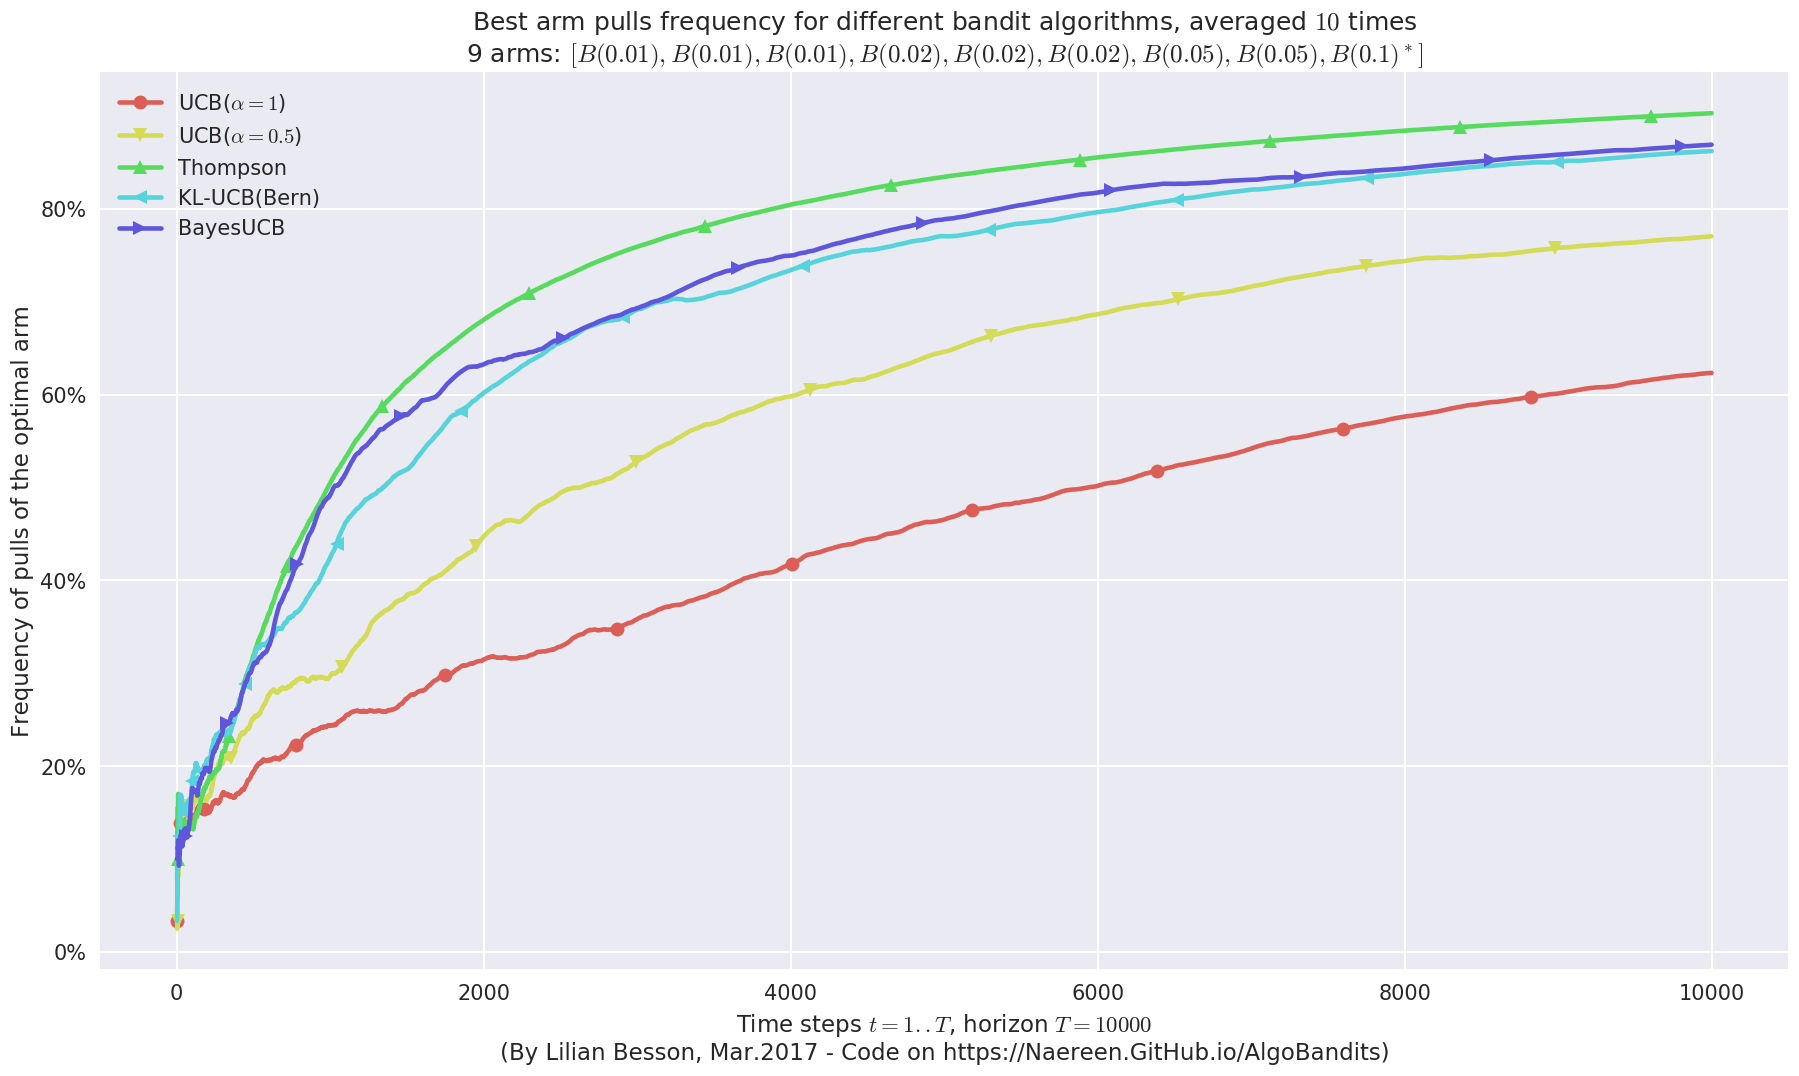

In [15]:
plotAll(evaluation, 2)

---
> That's it for this demo!